# Install and Import Libraries

In [ ]:
!pip install PyArabic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 2.7 MB/s eta 0:00:00


In [ ]:
!kaggle datasets download -d abedkhooli/arabic-100k-reviews
!unzip arabic-100k-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/abedkhooli/arabic-100k-reviews
License(s): copyright-authors
 94% 16.0M/17.0M [00:00<00:00, 66.0MB/s]
100% 17.0M/17.0M [00:00<00:00, 60.8MB/s]
Archive:  arabic-100k-reviews.zip
  inflating: ar_reviews_100k.tsv     


In [ ]:
import re
import pandas as pd

import pyarabic.araby as araby

import nltk
from nltk.corpus import stopwords
import nltk
from nltk.stem.isri import ISRIStemmer
nltk.download('stopwords')

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Bidirectional, SimpleRNN, LSTM

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load the dataset

In [ ]:
file_path = 'ar_reviews_100k.tsv'
df = pd.read_csv(file_path, sep='\t')

max_length = 250
min_length = 20

# I need to remove mixed reviews and set the longest text to 250 characters and the shortest to 20
df = df[df['label'] != 'Mixed']
df = df[df['text'].str.split().str.len().between(min_length, max_length)]

df.head()

,label,text
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
7,Positive,الكتاب هو السيرة الذاتية للحداثة في المملكة بل...
9,Positive,بشكل عام جيده .. . التجاوب جيد جدا من قبل موظف...


# Preproccess the text

In [ ]:
# Load the Arabic stopwords
arabic_stopwords = set(stopwords.words('arabic'))
# Load Arabic stemmer
st = ISRIStemmer()

# Define the function to clean the text
def clean_text(text):
    # Step 1: Remove links (URLs)
    # This regex pattern matches URLs and removes them from the text
    cleaned_text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Step 2: Remove special characters and punctuations
    # This removes any character that is not a word or whitespace
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)

    # Step 3: Remove Arabic diacritics (Tashkeel), and Tatweel
    # Tashkeel includes diacritical marks in Arabic (vowel sounds)
    cleaned_text = araby.strip_tashkeel(cleaned_text)  # Removes Tashkeel
    cleaned_text = araby.strip_tatweel(cleaned_text)   # Removes elongated letters
    cleaned_text = araby.strip_lastharaka(cleaned_text)  # Removes last haraka

    # Step 4: Tokenize the text (split the sentence into words)
    words = cleaned_text.split()

    # Step 5: Remove Arabic stopwords
    # This filters out any word that is part of the Arabic stopwords list
    filtered_words = [word for word in words if word not in arabic_stopwords]

    # Step 6: Apply stemming to the text
    stemmed_words = []
    for word in words:
      stemmed_words.append(st.stem(word))

    # Step 7: Join the filtered words back into a cleaned sentence
    stemmed_words = ' '.join(filtered_words)

    # Step 8: Normalize Hamza in the cleaned text
    cleaned_text = araby.normalize_hamza(stemmed_words)

    return cleaned_text

# Apply the clean_text function to the second row in the dataframe's 'text' column
cleaned_text = clean_text(df['text'][1])

# Print the original and cleaned text for comparison
print(f'Before: {df["text"][1]}')
print(f'After: {cleaned_text}')

Before: أحد أسباب نجاح الإمارات أن كل شخص في هذه الدولة يعشق ترابها. نحن نحب الإمارات. ومضات من فكر. نصائح لدولة تطمح بالصفوف الأولى و قائد لا يقبل إلا براحة شعبه وتوفر كل سب العيش الكريم. حكم و مواقف ونصائح لكل فرد فينا ليس بمجرد كتاب سياسي كما كنت اعتقد. يستحق القراءة مرات كثيرة
After: ءسباب نجاح الءمارات شخص الدولة يعشق ترابها نحب الءمارات ومضات فكر نصاءح لدولة تطمح بالصفوف الءولى قاءد يقبل براحة شعبه وتوفر سب العيش الكريم حكم مواقف ونصاءح لكل فرد فينا بمجرد كتاب سياسي كنت اعتقد يستحق القراءة مرات كثيرة


In [ ]:
df['clean_text'] = df['text'].apply(clean_text)

In [ ]:
df.head()

,label,text,clean_text
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...,ءسباب نجاح الءمارات شخص الدولة يعشق ترابها نحب...
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...,هادفة وقوية تنقلك صخب شوارع القاهرة الى هدوء ج...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...,خلصنا مبدءيا اللي مستني ابهار زي الفيل الازرق ...
7,Positive,الكتاب هو السيرة الذاتية للحداثة في المملكة بل...,الكتاب السيرة الذاتية للحداثة المملكة بلسان ءب...
9,Positive,بشكل عام جيده .. . التجاوب جيد جدا من قبل موظف...,بشكل عام جيده التجاوب جيد جدا موظفي الاستقبال ...


# Tokenize&Encode the data

In [ ]:
# Initialize the tokenizer
# Tokenizer will convert the text into a sequence of integers based on word frequency
tokenizer = Tokenizer()

# Fit the tokenizer on the 'clean_text' column of the dataframe
# This step builds the word index and counts word frequencies
tokenizer.fit_on_texts(df['clean_text'])

# Convert the text to sequences of integers
# Each word is replaced by its corresponding integer index from the tokenizer
sequences = tokenizer.texts_to_sequences(df['clean_text'])

# Pad the sequences to ensure uniform length (max_length) => this step is required because the input layer's size is fixed
# Padding is added to the end of the sequences ('post') if they are shorter than max_length
'''
⚠️ IMPORTANT ⚠️ IMPORTANT ⚠️ IMPORTANT ⚠️ IMPORTANT ⚠️
If you haven't defined the max_length, you can do the following:

max_length = df['text'].str.len().max()

This will give you the longest text in the 'text' column
'''
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Initialize the label encoder
# Label encoder will convert categorical labels into integer-encoded form
label_encoder = LabelEncoder()

# Fit and transform the 'label' column of the dataframe into integer labels
encoded_labels = label_encoder.fit_transform(df['label'])

# Split the data into training and testing sets
# Train-test split divides the data into training (80%) and testing (20%) sets
train_data, test_data, train_labels, test_labels = train_test_split(
    padded_sequences,     # The padded sequences are the feature data
    encoded_labels,       # The encoded labels are the target data
    test_size=0.2,        # 20% of the data is set aside for testing
    random_state=42       # Random seed for reproducibility of results
)

print("Shape of train_data:", train_data.shape)
print("Shape of train_labels:", train_labels.shape)
print("Shape of test_data:", test_data.shape)
print("Shape of test_labels:", test_labels.shape)

'''
Please note that the shape should look like this:

Shape of train_data: (n, max_length)
Shape of train_labels: (n,)
Shape of test_data: (n2, max_length)
Shape of test_labels: (n2,)

Where the n and n2 are the number of samples in the train and test sets, respectively. So the train_data and train_labels have n samples,
and the test_data and test_labels have n2 samples.
'''

Shape of train_data: (30167, 250)
Shape of train_labels: (30167,)
Shape of test_data: (7542, 250)
Shape of test_labels: (7542,)


'\nPlease note that the shape should look like this:\n\nShape of train_data: (n, max_length)\nShape of train_labels: (n,)\nShape of test_data: (n2, max_length)\nShape of test_labels: (n2,)\n\nWhere the n and n2 are the number of samples in the train and test sets, respectively. So the train_data and train_labels have n samples,\nand the test_data and test_labels have n2 samples.\n'

# Build & Train the Model

In [ ]:
# Define the Sequential model
model = Sequential([
    # Input layer, specifying the shape of the input data (e.g., sequence length)
    Input(shape=(max_length,)),

    # Embedding layer to convert integer-encoded words into dense vectors of fixed size
    # input_dim: size of the vocabulary (one more than the word index size to account for padding)
    # output_dim: size of the embedding vectors
    # input_length: the length of input sequences
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length),

    # Bidirectional RNN layer using SimpleRNN
    # 64 units in the RNN cell, return_sequences=True ensures that output is 3D (one output per time step)
    Bidirectional(SimpleRNN(64, return_sequences=True)),

    # Another Bidirectional SimpleRNN, this time returning only the final hidden state (2D output)
    Bidirectional(SimpleRNN(32)),

    # Dense layer (Fully connected layers)
    Dense(64, activation='relu'),

    # Output Dense layer with 1 unit (for binary classification) and sigmoid activation
    # Sigmoid activation squashes the output between 0 and 1, which is useful for binary classification
    Dense(1, activation='sigmoid')
])

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 250, 128)            │      24,747,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 250, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,786,881 (94.55 MB)

 Trainable params: 24,786,881 (94.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define the batch size for training and testing
batch_size = 32

# Create a TensorFlow Dataset from the training data and labels
# Dataset.from_tensor_slices creates a dataset with pairs of (input, label) tensors
train_dataset = tensorflow.data.Dataset.from_tensor_slices((train_data, train_labels))

# Create a TensorFlow Dataset from the testing data and labels
test_dataset = tensorflow.data.Dataset.from_tensor_slices((test_data, test_labels))

# Batch the datasets
# This will divide the dataset into batches of size 32 for efficient training
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Train the model using the training dataset
history = model.fit(train_dataset, epochs=5, validation_data=test_dataset)

Epoch 1/5
943/943 ━━━━━━━━━━━━━━━━━━━━ 121s 126ms/step - accuracy: 0.9409 - loss: 0.1587 - val_accuracy: 0.9456 - val_loss: 0.1465
Epoch 2/5
943/943 ━━━━━━━━━━━━━━━━━━━━ 128s 114ms/step - accuracy: 0.9950 - loss: 0.0167 - val_accuracy: 0.9312 - val_loss: 0.2450
Epoch 3/5
943/943 ━━━━━━━━━━━━━━━━━━━━ 140s 112ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 0.9379 - val_loss: 0.2642
Epoch 4/5
943/943 ━━━━━━━━━━━━━━━━━━━━ 103s 109ms/step - accuracy: 0.9998 - loss: 0.0014 - val_accuracy: 0.9373 - val_loss: 0.2728
Epoch 5/5
943/943 ━━━━━━━━━━━━━━━━━━━━ 106s 112ms/step - accuracy: 0.9999 - loss: 2.7748e-04 - val_accuracy: 0.9357 - val_loss: 0.3013


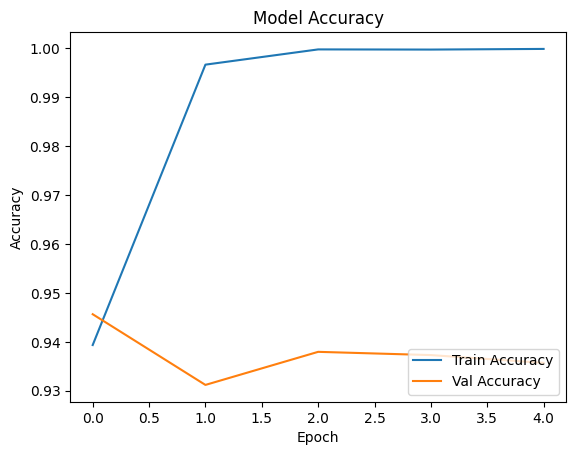

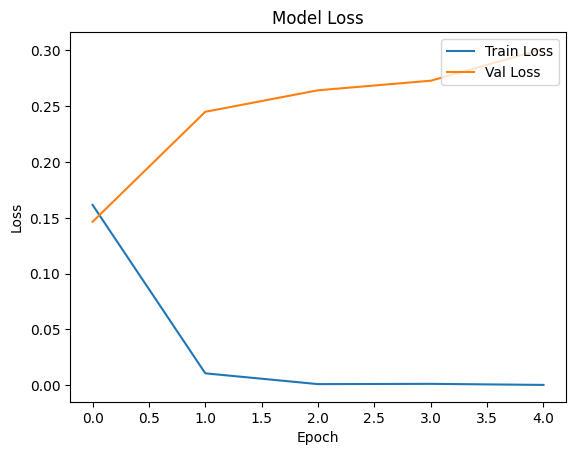

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
results = model.evaluate(test_data, test_labels)
print(f"Accuracy: {results[1] * 100:.2f}%")

236/236 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9351 - loss: 0.3049
Accuracy: 93.57%


# Inference, Predicting Labels for New Text Data

In [ ]:
# Define a sample text for prediction
sample_text = ["التجربة كانت سيئة جدا"]

# Clean the sample text (assuming there's a function clean_text() for text preprocessing)
# This step would typically involve removing unwanted characters, stopwords, etc.
sample_sequence = tokenizer.texts_to_sequences([clean_text(sample_text[0])])

# Pad the sequence to match the maximum length used during training
# Padding ensures that the input to the model has the same shape as the training data
padded_sample_sequence = pad_sequences(sample_sequence, maxlen=max_length, padding='post')

# Predict the label for the padded sample sequence using the trained model
predicted_label = model.predict(padded_sample_sequence)

# Print the predicted label by converting the integer-encoded prediction back to the original label
# The label_encoder.inverse_transform() method translates the encoded label back to its original form
print("Predicted label:", label_encoder.inverse_transform([predicted_label.argmax()]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
Predicted label: ['Negative']


In [ ]:
model.save('model.h5')